Suponga que desea utilizar Programación Genética para encontrar el diseño de un circuito
lógico, tome como, ejemplo el codificador de 7 segmentos. Describa el conjunto de
terminales, el conjunto de funciones y la función de aptitud. Use una librería de Python.

Utilizando la biblioteca DEAP para algoritmos evolutivos, implementando la Programación Genética (GP) encontramos un diseño de circuito lógico que represente un codificador de 7 segmentos.
**Definiciones Claves**


1. **Conjunto de terminales:** Entradas del sistema (bits BCD:𝐴,𝐵,𝐶,𝐷 A,B,C,D) y constantes lógicas (0, 1).
2. **Conjunto de funciones:** Operaciones lógicas básicas como AND, OR, NOT, XOR.
3. **Función de aptitud:** Mide qué tan bien el circuito generado produce las salidas correctas en comparación con la tabla de verdad del codificador de 7 segmentos.





gen	nevals	avg      	max      
0  	100   	0.0318285	0.0588235
1  	63    	0.0376574	0.0588235
2  	63    	0.0464554	0.0588235
3  	63    	0.0519861	0.0588235
4  	52    	0.0535187	0.0588235
5  	58    	0.0549538	0.0588235
6  	61    	0.0547325	0.0588235
7  	63    	0.0572463	0.0588235
8  	60    	0.0568461	0.0588235
9  	52    	0.0583765	0.0588235
10 	52    	0.0572261	0.0588235
11 	55    	0.056705 	0.0588235
12 	63    	0.056463 	0.0588235
13 	63    	0.0563401	0.0588235
14 	54    	0.0581307	0.0588235
15 	60    	0.0570349	0.0588235
16 	63    	0.0578196	0.0588235
17 	54    	0.0575942	0.0588235
18 	47    	0.0579629	0.0588235
19 	62    	0.0573563	0.0588235
20 	57    	0.0579449	0.0588235
21 	67    	0.0579929	0.0588235
22 	57    	0.0579871	0.0588235
23 	70    	0.0580326	0.0588235
24 	74    	0.0568631	0.0588235
25 	58    	0.0572902	0.0588235
26 	63    	0.0576398	0.0588235
27 	59    	0.0580668	0.0588235
28 	60    	0.0572899	0.0588235
29 	63    	0.057736 	0.0588235
30 	56    	0.0579603	0.0588235
31 	42  

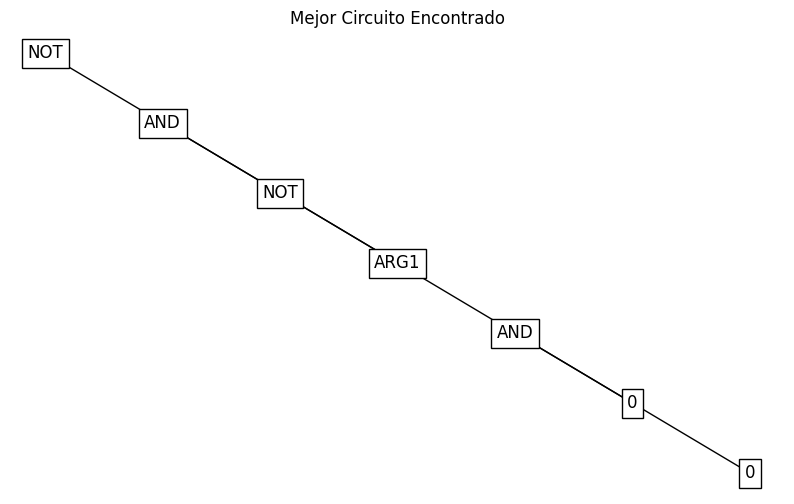

In [6]:
!pip install deap
import operator
import random
import numpy as np
import deap.gp as gp
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

# Definir las funciones lógicas básicas
def AND(a, b): return a & b
def OR(a, b): return a | b
def NOT(a): return ~a & 1
def XOR(a, b): return a ^ b

# Tabla de verdad para el codificador de 7 segmentos
truth_table = [
    [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],  # Segmento A
    [1, 1, 0, 0, 0, 0, 1, 1, 1, 1],  # Segmento B
    [1, 0, 0, 1, 1, 1, 1, 1, 1, 1],  # Segmento C
    [1, 0, 1, 1, 0, 1, 1, 1, 1, 1],  # Segmento D
    [1, 1, 1, 0, 0, 1, 1, 1, 1, 1],  # Segmento E
    [1, 1, 1, 1, 0, 0, 1, 1, 1, 1],  # Segmento F
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],  # Segmento G
]

# Creación de tipos para DEAP
pset = gp.PrimitiveSet("MAIN", 4)  # Cuatro entradas BCD
pset.addPrimitive(AND, 2)
pset.addPrimitive(OR, 2)
pset.addPrimitive(NOT, 1)
pset.addPrimitive(XOR, 2)
pset.addTerminal(0)
pset.addTerminal(1)

# Definir tipo de individuo
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genFull, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalCircuit(individual):
    func = gp.compile(expr=individual, pset=pset)
    error = 0
    for i in range(10):  # Evaluar con valores BCD del 0 al 9
        inputs = [int(x) for x in bin(i)[2:].zfill(4)]
        for j, expected in enumerate(truth_table):
            output = func(*inputs)
            error += (output != expected[i])
    return 1 / (1 + error),

toolbox.register("evaluate", evalCircuit)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)

# Algoritmo Evolutivo
def main():
    pop = toolbox.population(n=100)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("max", np.max)

    algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, stats=stats, halloffame=hof, verbose=True)
    return hof[0]

if __name__ == "__main__":
    best_circuit = main()
    print("Mejor circuito encontrado:", best_circuit)

    # Graficamos el mejor circuito
    nodes, edges, labels = gp.graph(best_circuit)
    fig, ax = plt.subplots(figsize=(10, 6))
    pos = {i: (i, -i) for i in range(len(nodes))}
    for i, j in edges:
        ax.plot([pos[i][0], pos[j][0]], [pos[i][1], pos[j][1]], 'k-', lw=1)
    for i, label in labels.items():
        ax.text(pos[i][0], pos[i][1], label, fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black'))
    ax.set_title("Mejor Circuito Encontrado")
    ax.axis("off")
    plt.show()
